In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import r2_score


In [2]:
os.chdir("FirstPart0.9")
os.getcwd()

'/home/users/t_wand01/Promotion/GLE Estimation/GLE Estimation Weekly/FirstPart0.9'

In [3]:

from os import listdir

directory_path = '.'
file_types = ['npy', 'npz']

np_vars = {dir_content: np.load(dir_content)
           for dir_content in listdir(directory_path)
           if dir_content.split('.')[-1] in file_types}

In [4]:
for i in np_vars.keys():
    print(i)

simulatedDataX_B10_K6_MAP.npy
theta_meanEst_B10_K6.npy
binsX_B10.npy
credibleIntervals_B10_K6.npy
SecondPart_WeeklyCorr.npy
MCMCsamples_raw_B10_K6.npy
MCMCsamples_B10_K6.npy
edgesX_B10.npy
theta_MAPest_B10_K6.npy
coeff_B10_K6.npy
FirstPart_WeeklyCorr.npy
simulatedDataX_B10_K6_mean.npy
theta_direct_SLE_B10.npy
n_bin_B10_K6.npy


In [5]:
os.chdir("..")
os.getcwd()
os.chdir("Predict")
os.getcwd()

'/home/users/t_wand01/Promotion/GLE Estimation/GLE Estimation Weekly/Predict'

## Edges of the Bins for Input Time Series Data

In [6]:
np_vars["edgesX_B10.npy"]

array([0.00523525, 0.08974787, 0.17426049, 0.25877311, 0.34328573,
       0.42779835, 0.51231097, 0.59682359, 0.68133621, 0.76584883,
       0.85036145])

## Estimated Parameters

- First ten parameters are for $D^{(1)}$
- Second ten parameters are for $D^{(2)}$
- Last six parameters are for Kernel $\mathcal{K}$

In [7]:
print(np.round(np_vars["theta_MAPest_B10_K6.npy"],3))



[ 0.025  0.008  0.005 -0.004 -0.019 -0.054 -0.024 -0.03  -0.029 -0.038
  0.009  0.01   0.015  0.018  0.021  0.03   0.026  0.038  0.041  0.015
 -0.214 -0.098 -0.12  -0.079 -0.027 -0.143]


In [8]:
# Into a pd.DataFrame

D1D2 = pd.DataFrame({"D1": np_vars["theta_MAPest_B10_K6.npy"][0:10],
                    "D2": np_vars["theta_MAPest_B10_K6.npy"][10:20]})
D1D2.head()

,D1,D2
0,0.025000,0.008905
1,0.008387,0.009969
2,0.005330,0.015351
3,-0.003526,0.018237
4,-0.018994,0.021025


Ensure that Kernel[1] is actually the lag-1-Kernel by adding a zeroth element

In [9]:
Kernel = [0]
Kernel += list(np_vars["theta_MAPest_B10_K6.npy"][20:])
print(np.round(Kernel,3))

[ 0.    -0.214 -0.098 -0.12  -0.079 -0.027 -0.143]


## Prediction

Taken from Eq. (7) in Clemens's Preprint

In [10]:
def getBin(x, Binning):
    # get Bin for observation x via Binning intervals Binning,
    # starts with zeroth Bin
    
    Output = int(sum(x>Binning)) - 1  
    # -1 because lowest interval boundary is minimum
    
    Output = max(0, Output) # if lower than min. in training data
    Output = min(len(Binning)-2, Output) # if higher than max. in training: N interval boundaries-> N-2 intervals
    
    return(int(Output))

    
    
getBin(0.36,np_vars["edgesX_B10.npy"])

4

In [11]:
print(np.round(np_vars["edgesX_B10.npy"],3))

[0.005 0.09  0.174 0.259 0.343 0.428 0.512 0.597 0.681 0.766 0.85 ]


In [12]:
def OneStep(X, d1d2_DF, Kernels, Binning, deltaT, K):
    # X: input data, d1d2_DF: DataFrame of D1 and D2, index = bins
    # Binning: intervals for binning, starts with zeroth Bin
    # deltaT : time increment, K: length of relevant kernel
    
    assert type(K) == int
    
    Interval = getBin(X[-1], Binning)
    
    Output = X[-1]  # past value
    Output +=  d1d2_DF["D1"].loc[Interval] * deltaT # simple Euler ODE
    
    # now for the kernel
    
    for k in range(1,K+1): # sum over 1 to (inclusive) K
        Contribution = 0
        Contribution += Kernel[k] * ( X[-1] - X[-1-k])*deltaT
        Output += Contribution # Kernel effect
    
    # now the stochastic Ito-component
    Output += np.sqrt(d1d2_DF["D2"].loc[Interval] * deltaT) * np.random.normal(0,1,1)

    
    return(Output)

In [13]:
def Prediction_mean_std(X, d1d2_DF, Kernels, Binning, deltaT, K, Times = 100):
    pred_list = list()
    for i in range(Times):
        pred_list = pred_list + list(OneStep(X, d1d2_DF, Kernels, Binning, deltaT, K))
        
    return( np.array([np.mean(pred_list), np.std(pred_list)]) )

## Test

In [14]:
X = np_vars["FirstPart_WeeklyCorr.npy"]

In [15]:
Prediction_mean_std(X, D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = 3)


array([0.52430303, 0.19407576])

In [16]:
m, std = Prediction_mean_std(X, D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = 3)
print(m)

0.5501072455325058


# In-Sample Prediction

In [17]:
K_Length = 3

In [18]:
Means = list()
Stds = list()
TrueValues = list()
LastValues = list()
L = len(X)-K_Length-1


for i in range(L):
    TrueValues = TrueValues +  [X[-L+i+1]]
    LastValues = LastValues+  [X[-L+i]]
    mn, st = Prediction_mean_std(X[:-L+i], D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length)
   
    Means = Means + [mn]
    Stds = Stds + [st]


### Some Confidence Interval Checks

In [19]:
LowerCI = np.array(Means)-np.array(Stds) 
UpperCI = np.array(Means)+np.array(Stds) 
ArrayTrueValues = np.array(TrueValues)

LCI_Check = 1.0*(LowerCI<ArrayTrueValues)
UCI_Check =1.0*(UpperCI>ArrayTrueValues)

InCI = LCI_Check * UCI_Check
print(np.mean(InCI))

0.6877637130801688


In [20]:
len(TrueValues)

948

In [21]:
len(X)

952

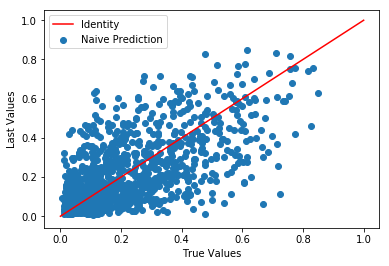

In [22]:
plt.scatter(TrueValues, LastValues, label="Naive Prediction")
plt.xlabel("True Values")
plt.ylabel("Last Values")
plt.plot([0,1],[0,1], label="Identity", c ="r")
plt.legend()
plt.show()

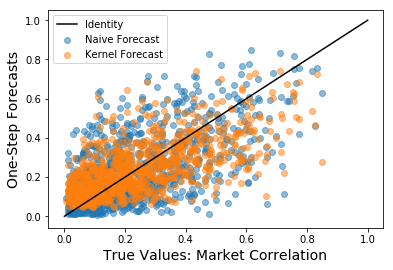

In [23]:
plt.scatter(TrueValues, LastValues, label="Naive Forecast", alpha = 0.5)

plt.scatter(TrueValues, Means, label="Kernel Forecast", alpha = 0.5)

fs = 14
plt.xlabel("True Values: Market Correlation",fontsize = fs)
plt.ylabel("One-Step Forecasts",fontsize = fs)
plt.plot([0,1],[0,1], label="Identity", c ="k")
plt.legend()
plt.show()

#### Root Mean Square Error and R² ### R² Metrics

In [24]:
np.sqrt(np.mean((np.array(TrueValues)-np.array(Means))**2.))

0.13438953268704262

In [25]:
np.sqrt(np.mean((np.array(TrueValues)-np.array(LastValues))**2.))

0.16001485352115827

In [26]:
r2_score(y_true=TrueValues, y_pred=Means)

0.42910811948551897

In [27]:
r2_score(y_true=TrueValues, y_pred=LastValues)

0.19063657392809652

# Out-Of-Sample Prediction

In [28]:
test_data = np_vars["SecondPart_WeeklyCorr.npy"]
len(test_data)

105

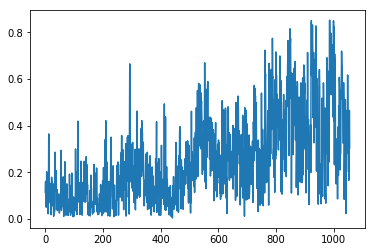

In [29]:
X_full = np.concatenate([X,test_data])
plt.plot(X_full)
plt.show()

In [30]:
Means_test = list()
Stds_test = list()
TrueValues_test = list()
LastValues_test = list()
L = len(test_data)+1  # +1 because first TrueValues is [X[-L+i+1]]


for i in range(L):
    TrueValues_test = TrueValues_test +  [X_full[-L+i+1]]
    LastValues_test = LastValues_test+  [X_full[-L+i]]
    mn, st = Prediction_mean_std(X_full[:-L+i], D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length)
   
    Means_test = Means_test + [mn]
    Stds_test = Stds_test + [st]


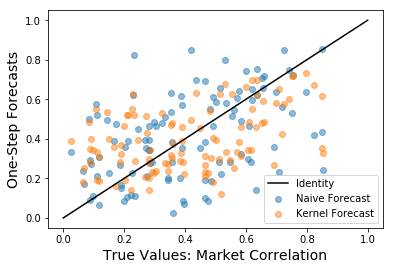

In [31]:
plt.scatter(TrueValues_test, LastValues_test, label="Naive Forecast", alpha = 0.5)

plt.scatter(TrueValues_test, Means_test, label="Kernel Forecast", alpha = 0.5)

fs = 14
plt.xlabel("True Values: Market Correlation",fontsize = fs)
plt.ylabel("One-Step Forecasts",fontsize = fs)
plt.plot([0,1],[0,1], label="Identity", c ="k")
plt.legend()
plt.show()

#### Root Mean Square Error and R² 

In [32]:
np.sqrt(np.mean((np.array(TrueValues_test)-np.array(Means_test))**2.))

0.20403579157788668

In [33]:
np.sqrt(np.mean((np.array(TrueValues_test)-np.array(LastValues_test))**2.))

0.22587837243543119

In [34]:
r2_score(y_true=TrueValues_test, y_pred=Means_test)

0.09613392776426466

In [35]:
r2_score(y_true=TrueValues_test, y_pred=LastValues_test)

-0.10774722298799988

### Again, CIs

In [36]:
LowerCI_test = np.array(Means_test)-np.array(Stds_test) 
UpperCI_test = np.array(Means_test)+np.array(Stds_test) 
ArrayTrueValues_test = np.array(TrueValues_test)

LCI_Check_test = 1.0*(LowerCI_test<ArrayTrueValues_test)
UCI_Check_test =1.0*(UpperCI_test>ArrayTrueValues_test)

InCI_test = LCI_Check_test * UCI_Check_test
print(np.mean(InCI_test))

0.5094339622641509
